In [1]:
import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext(master="local[4]")

In [2]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint

from string import split,strip

from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.tree import RandomForest, RandomForestModel

from pyspark.mllib.util import MLUtils

### Higgs data set
* **URL:** http://archive.ics.uci.edu/ml/datasets/HIGGS#  
* **Abstract:** This is a classification problem to distinguish between a signal process which produces Higgs bosons and a background process which does not.

**Data Set Information:**  
The data has been produced using Monte Carlo simulations. The first 21 features (columns 2-22) are kinematic properties measured by the particle detectors in the accelerator. The last seven features are functions of the first 21 features; these are high-level features derived by physicists to help discriminate between the two classes. There is an interest in using deep learning methods to obviate the need for physicists to manually develop such features. Benchmark results using Bayesian Decision Trees from a standard physics package and 5-layer neural networks are presented in the original paper. The last 500,000 examples are used as a test set.



In [3]:
#define feature names
feature_text='lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb'
features=[strip(a) for a in split(feature_text,',')]
print len(features),features

28 ['lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']


In [4]:
# create a directory called higgs, download and decompress HIGGS.csv.gz into it

from os.path import exists
if not exists('higgs'):
    print "creating directory higgs"
    !mkdir higgs
%cd higgs
if not exists('HIGGS.csv'):
    if not exists('HIGGS.csv.gz'):
        print 'downloading HIGGS.csv.gz'
        !curl -O http://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
    print 'decompressing HIGGS.csv.gz --- May take 5-10 minutes'
    !gunzip -f HIGGS.csv.gz
!ls -l
%cd ..

/CSE255-DSE230/CSE255-DSE230/Classes/HW-7/higgs
total 7847168
-rw-r--r-- 1 root root 8035497980 May 30 19:10 HIGGS.csv
/CSE255-DSE230/CSE255-DSE230/Classes/HW-7


### As done in previous notebook, create RDDs from raw data and build Gradient boosting and Random forests models. Consider doing 1% sampling since the dataset is too big for your local machine

In [5]:
# Read the file into an RDD
# If doing this on a real cluster, you need the file to be available on all nodes, ideally in HDFS.
path='higgs/higgs.csv'
inputRDD=sc.textFile(path)
#inputRDD.take(5)

In [8]:
# Transform the text RDD into an RDD of LabeledPoints
Data=inputRDD.map(lambda line: [float(strip(x)) for x in line.split(',')])\
     .map(lambda x: LabeledPoint(x[0], x[1:]))
Data.first()

LabeledPoint(1.0, [0.869293212891,-0.635081827641,0.22569026053,0.327470064163,-0.689993202686,0.754202246666,-0.24857313931,-1.09206390381,0.0,1.37499213219,-0.653674185276,0.930349111557,1.10743606091,1.13890433311,-1.57819831371,-1.0469853878,0.0,0.65792953968,-0.0104545699432,-0.0457671694458,3.10196137428,1.35376000404,0.979563117027,0.978076159954,0.920004844666,0.721657454967,0.988750934601,0.876678347588])

In [9]:
Data1=Data.sample(False,0.01).cache()
(trainingData,testData)=Data1.randomSplit([0.7,0.3])
print 'Sizes: Data1=%d, trainingData=%d, testData=%d'%(Data1.count(),trainingData.cache().count(),testData.cache().count())

Sizes: Data1=110402, trainingData=77048, testData=33354


In [10]:
counts=testData.map(lambda lp:(lp.label,1)).reduceByKey(lambda x,y:x+y).collect()
counts.sort(key=lambda x:x[1],reverse=True)
counts

[(1.0, 17694), (0.0, 15660)]

In [11]:
from time import time
errors={}
for depth in [1,3,6,10]:
    start=time()
    model=GradientBoostedTrees.trainClassifier(data=trainingData, categoricalFeaturesInfo={}, numIterations=10, maxDepth=depth)##FILLIN to generate 10 trees ##
    #print model.toDebugString()
    errors[depth]={}
    dataSets={'train':trainingData,'test':testData}
    for name in dataSets.keys():  # Calculate errors on train and test sets
        data=dataSets[name]
        Predicted=model.predict(data.map(lambda x: x.features))
        LabelsAndPredictions=data.map(lambda x: x.label).zip(Predicted) ### FILLIN ###
        Err = LabelsAndPredictions.filter(lambda (v,p):v != p).count()/float(data.count())
        errors[depth][name]=Err
    print depth,errors[depth],int(time()-start),'seconds'
print errors

1 {'test': 0.37024045092042934, 'train': 0.37148271207558925} 99 seconds
3 {'test': 0.33132457876116805, 'train': 0.32621223133630983} 105 seconds
6 {'test': 0.3013431672363135, 'train': 0.28901464022427575} 149 seconds
10 {'test': 0.3056904719074174, 'train': 0.19599470459973004} 549 seconds
{1: {'test': 0.37024045092042934, 'train': 0.37148271207558925}, 10: {'test': 0.3056904719074174, 'train': 0.19599470459973004}, 3: {'test': 0.33132457876116805, 'train': 0.32621223133630983}, 6: {'test': 0.3013431672363135, 'train': 0.28901464022427575}}


In [12]:
B10 = errors

Populating the interactive namespace from numpy and matplotlib


/root/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['split']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


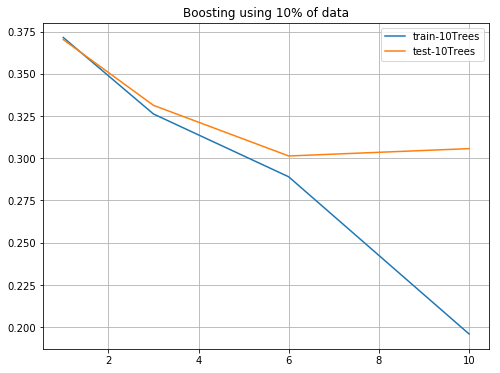

In [13]:
# Plot Train/test accuracy vs Depth of trees graph
%pylab inline
from plot_utils import *
make_figure([B10],['10Trees'],Title='Boosting using 10% of data')

In [15]:
from time import time
errors={}
for depth in [1,3,6,10,15,20]:
    start=time()
    model = RandomForest.trainClassifier(data=trainingData, numClasses=2, categoricalFeaturesInfo={}, numTrees=10, impurity="gini", maxDepth=depth)## FILLIN ##
    #print model.toDebugString()
    errors[depth]={}
    dataSets={'train':trainingData,'test':testData}
    for name in dataSets.keys():  # Calculate errors on train and test sets
        data=dataSets[name]
        Predicted=model.predict(data.map(lambda x: x.features))
        LabelsAndPredictions=data.map(lambda x: x.label).zip(Predicted)
        Err = LabelsAndPredictions.filter(lambda (v,p):v != p).count()/float(data.count())
        errors[depth][name]=Err
        ### FILLIN ###
    print depth,errors[depth],int(time()-start),'seconds'
print errors

1 {'test': 0.4209390178089584, 'train': 0.42486501920880493} 38 seconds
3 {'test': 0.3537506745817593, 'train': 0.35461011317620184} 40 seconds
6 {'test': 0.3278167536127601, 'train': 0.3194761706987852} 58 seconds
10 {'test': 0.30422138274269955, 'train': 0.26139549371820164} 125 seconds
15 {'test': 0.30539065779216884, 'train': 0.12875090852455612} 500 seconds
20 {'test': 0.31699346405228757, 'train': 0.03404371301007164} 3127 seconds
{1: {'test': 0.4209390178089584, 'train': 0.42486501920880493}, 3: {'test': 0.3537506745817593, 'train': 0.35461011317620184}, 6: {'test': 0.3278167536127601, 'train': 0.3194761706987852}, 10: {'test': 0.30422138274269955, 'train': 0.26139549371820164}, 15: {'test': 0.30539065779216884, 'train': 0.12875090852455612}, 20: {'test': 0.31699346405228757, 'train': 0.03404371301007164}}


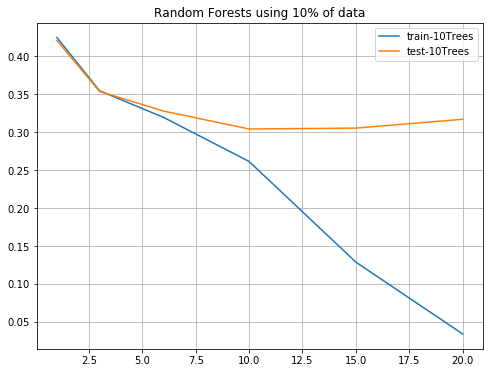

In [16]:
RF_10trees = errors
# Plot Train/test accuracy vs Depth of trees graph
make_figure([RF_10trees],['10Trees'],Title='Random Forests using 10% of data')

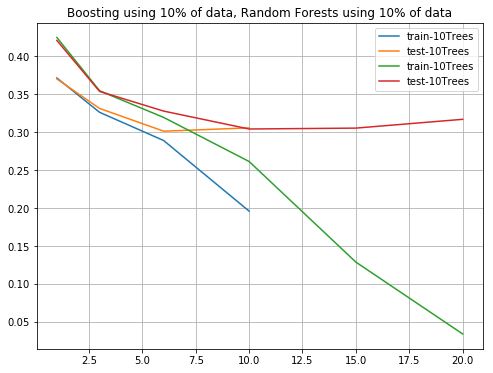

In [17]:
make_figure([B10, RF_10trees],['10GBTrees', '10RFTrees'], \
                               Title='Boosting using 10% of data, Random Forests using 10% of data')